In [1]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.utils import resample
from sklearn.ensemble import BaggingRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# 1
В файле «donation.csv» находится выборка с информацией об участниках программы
пожертвования денег на нужды ветеранских организаций. Каждая запись – один человек из
списка рассылки. У него есть социо-демографические признаки (пол, возраст, медианная
оценка дохода в районе его проживания, является ли он домовладельцем и т.д. и т.д.),
поведенческие признаки (агрегированные характеристики его ранних пожертвований типа
GiftCount36 – число пожертвований за три года, GiftAmntLast – сумма последнего
пожертвования, PromCntCard12 – число контактов с ним за год в рамках рекламной компании
и т.д.). Также есть два отклика: флаг TargetB (пожертвовал или нет) и TargetD – сумма
пожертвования (пропуск, если не жертвовал, иначе сумма в долларах). В рамках первой части
задания нужно построить регрессионные модели (только по людям, кто пожертвовал деньги),
объясняющие и прогнозирующие сумму пожертвования TargetD.

In [2]:
df = pd.read_csv("train.csv")

df1 = df.copy()
df1.set_index("ID", inplace=True)
df1 = df1[df1["TargetB"] == 1]
df1.drop(columns="TargetB", inplace=True)
#df1.reset_index(drop=True, inplace=True)

# "ID" "TargetB" "TargetD"
Currency = ["GiftAvgLast", "GiftAvg36", "GiftAvgAll", "GiftAvgCard36", "DemMedHomeValue", "DemMedIncome"]
Character = ["StatusCat96NK", "DemGender", "DemHomeOwner"] # "DemCluster" ?
Numeric = ["GiftCnt36", "GiftCntAll", "GiftCntCard36", "GiftCntCardAll", "GiftTimeLast", "GiftTimeFirst",
           "PromCnt12", "PromCnt36", "PromCntAll", "PromCntCard12", "PromCntCard36", "PromCntCardAll",
           "StatusCatStarAll", "DemAge", "DemPctVeterans"]

for i in Currency + ["TargetD"]:
    column_to_transform = df1[i]
    column_transformed = column_to_transform.str.replace("$", "", regex=False)
    column_transformed = column_transformed.str.replace(",", "", regex=False)
    column_numeric = pd.to_numeric(column_transformed)
    df1[i] = column_numeric

for i in Character:
    print(i, df[i].unique())

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df1[Character])

temp_df = pd.DataFrame(data=ohe.transform(df1[Character]), columns=ohe.get_feature_names_out(), index = df1.index)
df1.drop(columns=Character, inplace=True)
df1 = pd.concat([df1, temp_df], axis=1)

df1

StatusCat96NK ['A' 'S' 'E' 'F' 'N' 'L']
DemGender ['F' 'M' 'U']
DemHomeOwner ['U' 'H']


,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,...,StatusCat96NK_E,StatusCat96NK_F,StatusCat96NK_L,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U
ID,,,,,,,,,,,,,,,,,,,,,
46110,4.0,6,41,3,20,6.0,5.17,3.73,5.00,18,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
185937,10.0,3,12,3,8,10.0,8.67,8.50,8.67,9,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
112632,11.0,3,11,2,9,11.0,10.33,8.27,8.00,22,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
19094,40.0,1,3,0,1,35.0,35.00,28.33,NaN,17,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
102224,6.0,3,16,2,13,6.0,6.33,6.13,6.00,17,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184644,20.0,1,1,1,1,25.0,25.00,25.00,25.00,20,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
184690,20.0,1,1,0,0,15.0,15.00,15.00,NaN,20,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
184723,10.0,1,4,1,3,20.0,20.00,16.25,20.00,17,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# 2
Выберите и сохраните в качестве проверочной выборки (holdout) 30% исходной выборки со
стратификацией по отклику. Обратите внимание, что отклик непрерывный и его нужно
дискретизировать. Число интервалов и метод дискретизации выберите самостоятельно.
Постройте и визуализируйте гистограмму (или kde апроксимацию) для распределения отклика
во всем исходном наборе, в проверочной и в тренировочной выборках.

[array([  1.,  10.,  13.,  20., 200.])]


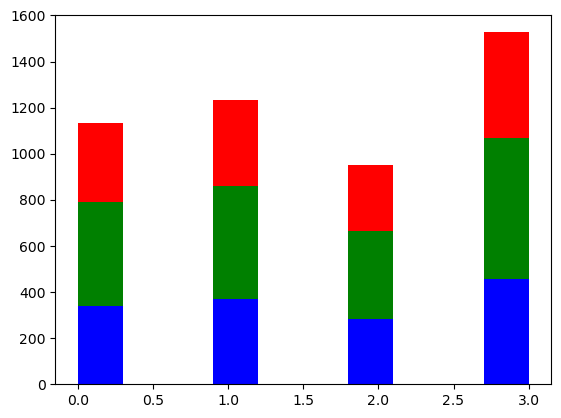

In [3]:
df2 = df1.copy()

y = df2["TargetD"].to_frame()
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', random_state=123)
est.fit(y)
print(est.bin_edges_)
df2["TargetD"] = est.transform(y)

X = df2.drop(columns="TargetD")
y = df2["TargetD"].to_frame()

X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.3, random_state=123, shuffle=True, stratify=y)

plt.hist(y, color="red")
plt.hist(y_train, color="green")
plt.hist(y_test, color="blue");

# 3
На этапе предобработки данных сделайте подстановку пропусков методом из вашего варианта
с сохранением бинарных признаков о том, какие переменные были проимпутированы.
Преобразования категориальных переменных с помощью WOE, Target encoding, Threshold
encoding и других методов, а также преобразование числовых переменных (для получения
более симметричных распределений с помощью log или Box-Cox) приветствуется, но не
обязательно.

SimpleImputer (median)

In [4]:
to_impute = []

for i in X_train.columns:
    if X_train[i].isnull().any() or X_test[i].isnull().any():
        to_impute.append(i)

print(to_impute)
        
for i in to_impute:
    X_train[i+"_imputed"] = X_train[i].isna().astype(int)
    X_test[i+"_imputed"] = X_test[i].isna().astype(int)
        
imp_median = SimpleImputer(strategy="median")

imp_median.fit(X_train[to_impute])
X_train[to_impute] = imp_median.transform(X_train[to_impute])

imp_median.fit(X_test[to_impute])
X_test[to_impute] = imp_median.transform(X_test[to_impute])
X_train

['GiftAvgCard36', 'DemAge', 'DemMedIncome']


,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,GiftTimeFirst,...,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U,GiftAvgCard36_imputed,DemAge_imputed,DemMedIncome_imputed
ID,,,,,,,,,,,,,,,,,,,,,
90350,3,6,2,3,20.0,16.67,13.33,15.00,26,65,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0
128522,10,48,9,27,11.0,10.20,9.06,10.22,17,130,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,1,1
104891,2,10,1,6,20.0,15.00,12.60,15.00,17,86,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1
24663,6,14,2,5,17.0,14.83,10.07,14.00,16,81,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1
157106,4,32,4,19,36.0,28.00,19.31,28.00,20,128,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184496,4,10,3,8,10.0,10.00,9.00,10.00,19,79,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0
123805,4,12,4,8,10.0,5.25,4.58,5.25,21,76,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
178334,7,12,3,7,10.0,11.43,9.17,9.67,15,80,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,0


# 4
Произведите отбор важных переменных с помощью линейного регрессионного метода из
вашего варианта, перебрав все возможные сложности моделей в рамках вашего метода и
выбрав лучшую по кросс-валидации c 5 блоками и MSE в качестве критерия. В пошаговых
регрессионных методах для остановки и выбора следующего шага используйте R-квадрат, pvalue или AIC на ваше усмотрение. Постройте график зависимости CV-MSE от сложности (число
переменных или число компонент в модели), график трассы стандартизованных
коэффициентов от сложности. Вертикальной линией на этих графиках обозначьте лучшую по CV
сложность модели.

Backward OLS

0.7500307536535682


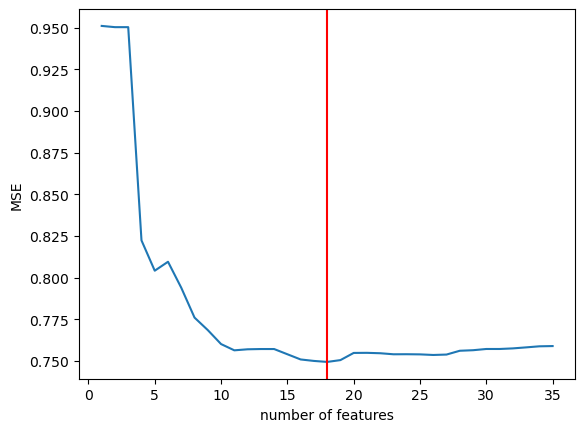

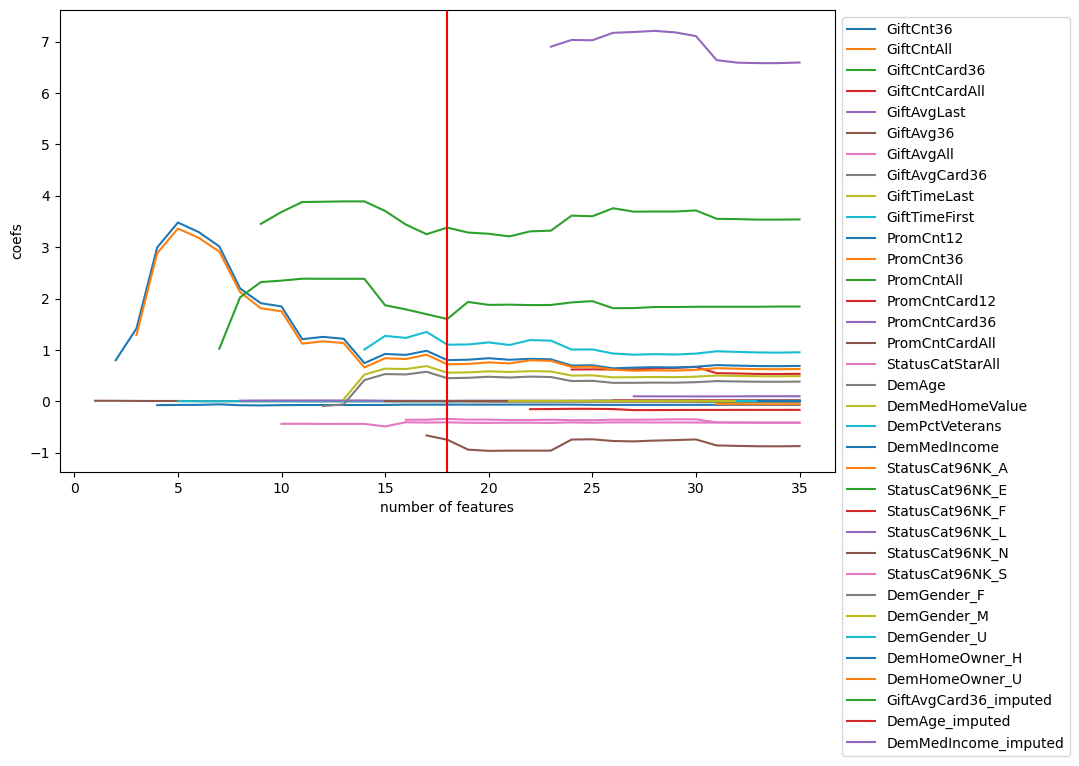

In [5]:
features = list(X_train.columns)
best_features = None
errs = []
complexity = []
coef_list = []

while len(features) > 0:
    scores = cross_val_score(
        LinearRegression(), X_train[features], y_train, cv=5, scoring="neg_mean_squared_error")
    mse = -np.mean(scores)

    errs.append(mse)
    complexity.append(len(features))

    if mse == min(errs):
        best_features = features.copy()

    model = sm.OLS(y_train, X_train[features])
    res = model.fit()
    
    coefs = res.params / np.std(X_train[features], axis=0)
    coef_list.append(coefs.to_frame().T)
    
    worst_feature = res.pvalues.idxmax()
    features.remove(worst_feature)

print(errs[len(best_features)])

plt.plot(complexity, errs)
plt.axvline(x = len(best_features), color="red")
plt.xlabel("number of features")
plt.ylabel("MSE")
plt.show()

res = pd.DataFrame(columns=X_train.columns)
res = pd.concat([res, *coef_list], ignore_index=True)
#res = res.fillna(0)

plt.figure(figsize=(10, 6))
plt.plot(complexity, res.to_numpy())
plt.axvline(x = len(best_features), color="red")
plt.xlabel("number of features")
plt.ylabel("coefs")
plt.legend(X_train.columns, bbox_to_anchor=(1.0, 1.0))
plt.show();

# 5
Для лучшей выбранной сложности линейной модели с помощью бутстреппинга (100 бутстреп
выборок размера 25% от исходной) постройте гистограммы (или kde аппроксимацию)
распределения константы смещения в полученном регрессионном уравнении (константы b
если регрессии y=ax+b) с указанием на графике среднего значения и 95% интервала.
Аналогично оцените OOB ошибку MSE. Как она соотносится с лучшей кросс-валидационной
ошибкой и ошибкой на проверочной части выборки?

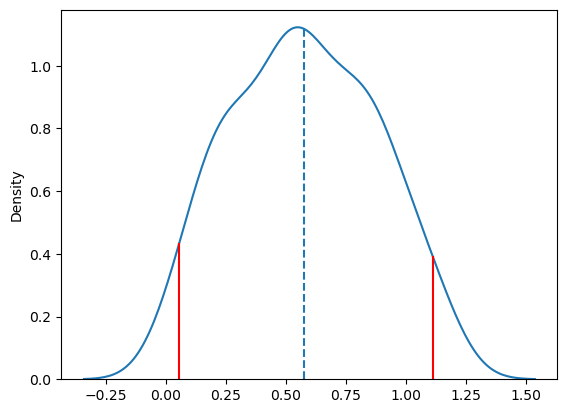

0.4435284217785419
0.7451909381295974
0.8028273161314136


In [6]:
def draw(arr):
    obj = sns.kdeplot(arr)
    line = obj.get_lines()[0]
    
    plt.axvline(arr.mean(),
            ymax=line.get_ydata()[np.abs(line.get_xdata() - arr.mean()).argmin()] / obj.get_ylim()[1],
            ls="--")
    
    plt.axvline(np.quantile(arr, 0.025),
            ymax=line.get_ydata()[np.abs(line.get_xdata() - np.quantile(arr, 0.025)).argmin()] / obj.get_ylim()[1],
            c="red")
    
    plt.axvline(np.quantile(arr, 0.975),
            ymax=line.get_ydata()[np.abs(line.get_xdata() - np.quantile(arr, 0.975)).argmin()] / obj.get_ylim()[1],
            c="red")
    
    plt.show()


estimator = BaggingRegressor(LinearRegression(), n_estimators=100, max_samples=0.25, bootstrap=True,
                              oob_score=True, random_state=123, n_jobs=-1)

estimator.fit(X_train[best_features], y_train["TargetD"])

b = []
for i in estimator.estimators_:
    b.append(i.intercept_)

b = np.array(b)
draw(b)

print(estimator.oob_score_)

print(mean_squared_error(y_train, estimator.oob_prediction_))

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))

# 6
Используйте отобранные переменные для построения нелинейной модели прогнозирования
числового отклика с помощью метода из вашего варианта, при этом отбирая метапараметры
также с помощью метода из вашего варианта. Замечания:
- В PLS регрессиях для отбора переменных (после отбора числа компонент по кроссвалидации) используйте VIP статистику с любым порогом в диапазоне [0.5,1].
- Обратите внимание, что категориальные переменные можно либо включить в модель
целиком (со всеми уровнями), либо не включать.
- Для однослойного MLP можно варьировать число нейронов и константу регуляризации,
для GAM – константу регуляризации и число узлов в сплайне, для полиномиальной
гребневой регрессии - константу регуляризации и степень полинома.

MLP (tanh) , HalvingRandomSearchCV

In [7]:
param_grid = {
    'hidden_layer_sizes': [(18 + 2 * i,) for i in range(5)],
    'alpha': [14 + 2 * i for i in range(5)]
}

model = MLPRegressor(activation='tanh', max_iter=10000)

HRS = HalvingRandomSearchCV(model, param_grid, scoring='neg_mean_squared_error', random_state=123, n_jobs=-1)

HRS.fit(X_train[best_features], y_train["TargetD"])

print(HRS.best_params_)

model = MLPRegressor(**HRS.best_params_, activation='tanh', max_iter=10000, random_state=123)

/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 25 is smaller than n_iter=339. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'hidden_layer_sizes': (24,), 'alpha': 22}


# 7
Постройте график – «решетку» перебора метапараметров, цветом указав качество моделей, а
размером точек – число повторов для halving). Сравните CV, OOB и holdout оценки качества
полученных линейных и нелинейных моделей, какие выводы из этого можно сделать?

0.5411903448825649
0.5923592287829469
0.5458862961051668
0.6067631041378874


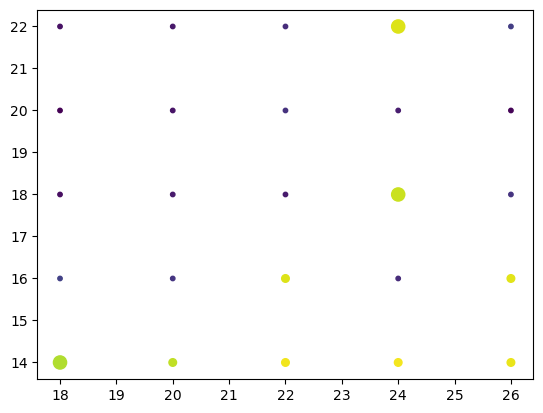

In [8]:
d = pd.DataFrame(HRS.cv_results_["params"]).T.values

plt.scatter([i for i in d[0]], d[1],
            c=HRS.cv_results_["mean_test_score"],
            s=HRS.cv_results_["n_resources"])

scores = cross_val_score(model, X_train[best_features], y_train["TargetD"], cv=5, scoring="neg_mean_squared_error")
print(-np.mean(scores))

estimator = BaggingRegressor(
    model, n_estimators=100, max_samples=0.25, bootstrap=True, oob_score=True, random_state=123, n_jobs=-1)

estimator.fit(X_train[best_features], y_train["TargetD"])
print(estimator.oob_score_)
print(mean_squared_error(y_train, estimator.oob_prediction_))

model.fit(X_train[best_features], y_train["TargetD"])
predicted = model.predict(X_test[best_features])
print(mean_squared_error(y_test, predicted))

Нелинейная модель лучше соответствует структуре данных. Нелинейная модель лучше аппроксимирует сложные зависимости переменных и предсказывает отклик точнее.

# 8
«Творческое задание» на классификацию. Целью задания является освоение алгоритмов и
методов прогнозирования для решения учебной задачи анализа данных в условиях, близких к
реальным условиям, возникающим при решении прикладных задач анализа данных. Дан тот
же набор данных с известным откликом, а также тестовый набор “test.csv”, где реальный отклик
не будет известен вам, но будет известен проверяющему. Необходимо построить модель,
которая выберет среди людей из набора test.csv тех, кому имеет смысл делать предложение о
пожертвовании при условии, что стоимость контакта с каждым человеком фиксированная и
равна 0.68 USD. Таким образом вы можете использовать три различных подхода:
- С помощью модели прогнозировать сумму пожертвования P_TargetD (с учетом того, что
есть много нулей) и сформировать список ID, кому стоит делать предложение, у кого
ожидаемая сумма P_TargetD> 0.68.
- C помощью нелинейной модели прогнозировать вероятность положительного отклика
P_TargetB и считать ожидаемую сумму пожертвования (риск) как P_TargetB *E(TargetD)-
0.68*(1- P_TargetB), выбирать тех, у кого ожидаемая сумма (положительный риск) будет
больше нуля. В качестве средней оценки E(TargetD) можно брать мат. ожидание,
медиану или другую оценку центра масс или моды распределения.
- С помощью двух моделей или с помощью одной модели (например, нейросети с двумя
выходами): одна для прогноза суммы P_TargetD, вторая для прогноза вероятности
пожертвования P_TargetB, посчитать тот же риск, что и в варианте выше: P_TargetB
*P_TargetD-0.68*(1- P_TargetB) и выбрать по нему.

Третий вариант самый правильный, но самый сложный. Оцениваться качество модели будет
так:
- На тестовом наборе, где реальный отклик не будет известен студенту (вам), но будет
известен проверяющему (мне) нужно применить свою модель (свои модели) и переслать
вместе с JN csv файл с одной колонкой отобранных ID из тестового набора.
- С учетом того, что в тестовом наборе у проверяющего есть информация о факте и сумме
пожертвования в качестве оценки будет использоваться общая сумма, собранная по
отобранным клиентам с учетом стоимости контакта.
- Для сдачи задания необходимо получить сумму на тестовом наборе больше \$11K (у случая
«выбрать всех без моделирования» сумма где-то \$10K). Набравшие больше \$14K получают
экзамен автоматом (если смогут объяснить как строится и работает модель) вне
зависимости от посещаемости и сдачи других заданий.

При решении задачи можно использовать любые открытые общедоступные на python пакеты и
алгоритмы, рассмотренные в курсе, включая sklearn, pytourch, keras и другие. При использовании
алгоритмов, не рассмотренных в курсе, нужно быть готовым подробно рассказать про построенную
модель и методы построения.

In [9]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv") #DemIncomeGroup DemMedIncome=NaN

df.set_index("ID", inplace=True)
df_test.set_index("ID", inplace=True)

df.drop(columns="DemMedIncome", inplace=True)
df_test.drop(columns="DemMedIncome", inplace=True)
df_test.drop(columns="DemIncomeGroup", inplace=True)

def process_currency(df, features):
    for i in features:
        column_to_transform = df[i]
        column_transformed = column_to_transform.str.replace("$", "", regex=False)
        column_transformed = column_transformed.str.replace(",", "", regex=False)
        column_numeric = pd.to_numeric(column_transformed)
        df[i] = column_numeric

Currency = ["GiftAvgLast", "GiftAvg36", "GiftAvgAll", "GiftAvgCard36", "DemMedHomeValue"]
        
process_currency(df, Currency + ["TargetD"])
process_currency(df_test, Currency)

def OHE(df, features):
    ohe = OneHotEncoder(sparse_output=False)
    ohe.fit(df[features])

    temp_df = pd.DataFrame(data=ohe.transform(df[features]), columns=ohe.get_feature_names_out(), index = df.index)
    df.drop(columns=features, inplace=True)
    df = pd.concat([df, temp_df], axis=1)
    return df

df = OHE(df, Character)
df_test = OHE(df_test, Character)

df["TargetD"] = df["TargetD"].fillna(0)


to_impute = []

for i in df_test.columns:
    if df[i].isnull().any() or df_test[i].isnull().any():
        to_impute.append(i)
        
for i in to_impute:
    df[i+"_imputed"] = df[i].isna().astype(int)
    df_test[i+"_imputed"] = df_test[i].isna().astype(int)
        
imputer = SimpleImputer(strategy="mean")

imputer.fit(df[to_impute])
df[to_impute] = imputer.transform(df[to_impute])

imputer.fit(df_test[to_impute])
df_test[to_impute] = imputer.transform(df_test[to_impute])


yb = df["TargetB"]
yd = df["TargetD"]
X = df.drop(columns=["TargetB", "TargetD"])

In [10]:
param_grid = {
    'hidden_layer_sizes': [(10,), (50,)],
    'alpha': [1, 20]
}

def get_model(X, y, max_iter=10000):
    complexity = []
    mse = []
    scores = []
    params = []
    features = []

    for i in range(1, X.shape[1] + 1):
        selector = SelectKBest(f_regression, k=i).fit(X, y)
        best_features = X.columns[selector.get_support()]
        
        model = MLPRegressor(activation='tanh', max_iter=max_iter, random_state=123)
        HRS = HalvingRandomSearchCV(model, param_grid, scoring='neg_mean_squared_error', random_state=123, n_jobs=-1)
        HRS.fit(X[best_features], y)

        model = MLPRegressor(**HRS.best_params_, activation='tanh', max_iter=max_iter, random_state=123)

        estimator = BaggingRegressor(
            model, n_estimators=100, max_samples=0.25, bootstrap=True, oob_score=True, random_state=123, n_jobs=-1)

        estimator.fit(X[best_features], y)
        
        complexity.append(i)
        features.append(best_features)
        params.append(HRS.best_params_)
        mse.append(mean_squared_error(y, estimator.oob_prediction_))
        scores.append(estimator.oob_score_)
        
    idx = mse.index(min(mse))
    print(min(mse),idx)
        
    model = MLPRegressor(**params[idx], activation='tanh', max_iter=max_iter, random_state=123)
    
    model.fit(X[features[idx]], y)
    
    plt.plot(complexity, mse)
    plt.show()
    
    return model, features[idx]

/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfav

0.24207480998165065 12


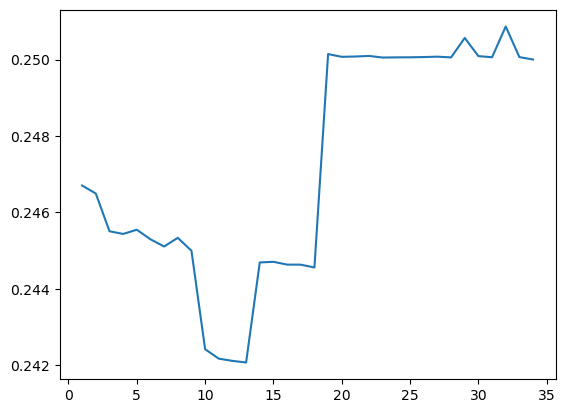

MLPRegressor(activation='tanh', alpha=1, hidden_layer_sizes=(10,),
             max_iter=10000, random_state=123)

In [11]:
modelb, featuresb = get_model(X, yb, max_iter=10000)
modelb

/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfavour/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=968. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/disfav

127.32560332270305 0


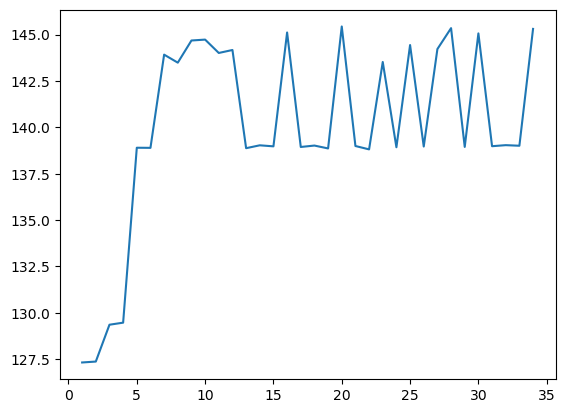

MLPRegressor(activation='tanh', alpha=20, hidden_layer_sizes=(50,),
             max_iter=100000, random_state=123)

In [12]:
modeld, featuresd = get_model(X, yd, max_iter=100000)
modeld

In [14]:
yb_predicted = modelb.predict(df_test[featuresb])
yd_predicted = modeld.predict(df_test[featuresd])

res = df_test.copy()
res["res"] = yb_predicted*yd_predicted - 0.68*(1-yb_predicted)
res = res[res["res"] >= 0]
res = res.reset_index()
res["ID"].to_csv("out.csv", index=False)

In [20]:
res

,ID,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,...,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U,GiftAvgCard36_imputed,GiftTimeFirst_imputed,DemAge_imputed,res
0,3,2,12,1,6,25.0,22.50,21.25,20.000000,18,...,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,4.509754
1,6,7,22,4,6,10.0,5.71,5.36,5.250000,5,...,0.0,0.0,1.0,0.0,0.0,1.0,0,0,1,3.825629
2,9,5,16,3,8,12.0,12.80,10.75,13.000000,16,...,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1,3.852117
3,11,1,15,0,4,27.0,27.00,17.80,15.309854,18,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,3.796194
4,16,5,21,2,7,25.0,21.60,20.10,20.000000,15,...,1.0,1.0,0.0,0.0,0.0,1.0,0,0,0,6.182260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96317,191769,1,3,0,1,20.0,20.00,16.67,15.309854,19,...,0.0,0.0,1.0,0.0,1.0,0.0,1,0,0,2.635977
96318,191771,3,22,3,12,10.0,8.00,6.14,8.000000,21,...,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,2.790968
96319,191773,3,3,2,2,100.0,38.67,38.67,8.000000,19,...,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,11.401085
96320,191774,2,11,0,7,10.0,10.00,9.64,15.309854,18,...,1.0,0.0,0.0,1.0,0.0,1.0,1,0,0,1.296029


In [19]:
res["res"].describe()

count    96322.000000
mean         3.117775
std          1.258506
min          0.002686
25%          2.439570
50%          2.893196
75%          3.479670
max         22.034974
Name: res, dtype: float64